In [1]:
import torch.optim as optim
from utils import *
from model import *
import config
from train import *
from scipy.stats import truncnorm
import torch


c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load weight

In [2]:
gen = Generator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)
critic = Discriminator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))

In [3]:
def generate_examples(gen, steps, root_path, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, config.Z_DIM, 1, 1)),
                                 device=config.DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            save_image(img * 0.5 + 0.5, f"../{root_path}/saved_examples/img_{i}.png")
    gen.train()

In [4]:
load_checkpoint('../../weightCelebA//generator.pth', gen, opt_gen, config.LEARNING_RATE)
generate_examples(gen, 3, root_path= 'fakeCeleba', n = 200)
load_checkpoint('../../weightCiFAR//generator.pth', gen, opt_gen, config.LEARNING_RATE)
generate_examples(gen, 3, root_path= 'fakeCIFAR', n = 200)

=> Loading checkpoint
=> Loading checkpoint


In [5]:
import cv2
# Load image in LAB format
lab_img = cv2.imread('../fakeCeleba/saved_examples/img_1.png', cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)

# Convert LAB image to RGB
rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
print(type(rgb_img))
# plt.imshow(rgb_img)

<class 'numpy.ndarray'>


In [6]:
steps = [0,1,2,3,4]
alpha = 1

In [7]:
# Generate 1 anh duy nhat 
with torch.no_grad():
    generated_images = []
    noise = torch.tensor(truncnorm.rvs(-0.7, 0.7, size=(1, config.Z_DIM, 1, 1)),
                            device=config.DEVICE, dtype=torch.float32)
    img = gen(noise, alpha, steps[3])
    print(img.shape)
    generated_images.append(img)
    generated_images = torch.cat(generated_images, dim = 0)
    print(generated_images.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [8]:
# Load CIFAR (real data)    
real_loader, datasets = get_loader_CIFAR(4 * 2 ** steps[3])
real_C, labels = next(iter(real_loader))

100%|██████████| 170498071/170498071 [06:13<00:00, 456751.35it/s] 


Extracting ../../data\cifar-10-python.tar.gz to ../../data


In [9]:
# Load CelebA (real data)    
real_loader, datasets = get_loader(4 * 2 ** steps[3], r"../../Celeba_dataset/img_align_celeba")
real_Ce, labels = next(iter(real_loader))

In [10]:
from train import *
# Load generated images CelebA (fake data)
fake_loader, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCeleba")
fake_CE, labels = next(iter(fake_loader))

In [11]:
from train import *
# Load generated images CelebA (fake data)
fake_loader, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCIFAR")
fake_C, labels = next(iter(fake_loader))

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


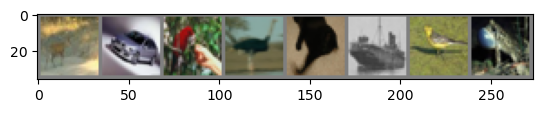

In [39]:
imshow(torchvision.utils.make_grid(real_C[:8]))

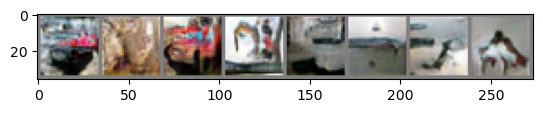

In [40]:
# fixed_fakes = gen(config.FIXED_NOISE, alpha, steps[3])
imshow(torchvision.utils.make_grid(fake_C[:8]))

In [ ]:
# FID = ||mu1 - mu2||^2 + Tr(C1 + C2 - 2(C1*C2)^(1/2))
def fid_score(mur, muf, stdr, stdf):
    return np.sqrt(muf**2 + mur**2) + (stdf + stdr - 2 * np.sqrt(stdf * stdr))

In [54]:
print("Calculating Inception Score for CelebA dataset: ")
std_Ce, means_Ce = inception_score(real_Ce, cuda=False, batch_size=10, resize=True)
print(std_Ce, means_Ce)
std_fake, means_fake = inception_score(fake_CE, cuda=False, batch_size=10, resize=True)
print(std_fake, means_fake)

Calculating Inception Score for CelebA dataset: 
1.3971295673319073 0.17374533862059258
1.3598499747196517 0.08991757896950625


In [56]:
print("Calculating Inception Score for CelebA dataset: ")
fid_score(means_Ce, means_fake, std_Ce, std_fake)

0.1958859335905176

In [62]:
print("Calculating Inception Score for CIFAR10 dataset: ")
std_C, means_C = inception_score(real_C, cuda=False, batch_size=10, resize=True)
print(std_Ce, means_Ce)
std_fake, means_fake = inception_score(fake_C, cuda=False, batch_size=10, resize=True)
print(std_fake, means_fake)

Calculating Inception Score for CIFAR10 dataset: 
1.3971295673319073 0.17374533862059258
1.6313273361652119 0.2149820527426019


In [63]:
fid_score(means_C, means_fake, std_C, std_fake)

0.24986676054697773